1. In AI, datasets are often very large and cannot be processed all at once as is done in the loop above. The data is instead randomly sampled in smaller _batches_ where each _batch_ contains `batch_size` inputs. How can you change the loop above to sample the dataset in smaller batches? Hint: Our `data` variable is a Pandas `DataFrame` object, search for "how to sample a DataFrame".

I implemented batching by adding a sampling step to my sgd function. At the start of each iteration the input DataFrame is sampled with n = batchSize which is then converted to a numpy array.

2. As described above, learning rates that grow smaller over time can help find and get closer to global minima. In the loop above, our `learning_rate_m` and `learning_rate_b` are constant through the process of minimizing our parameters. How could you change the loop to reduce the learning rates over loop iterations?

I implemented an exponential decay function (calc_decay) to decrease the learning rates of m and b during each iteration of the sgd.

SGD:     y = 87.13 * x + 34583.96
Lin Reg: y = 87.69 * x + 34754.08


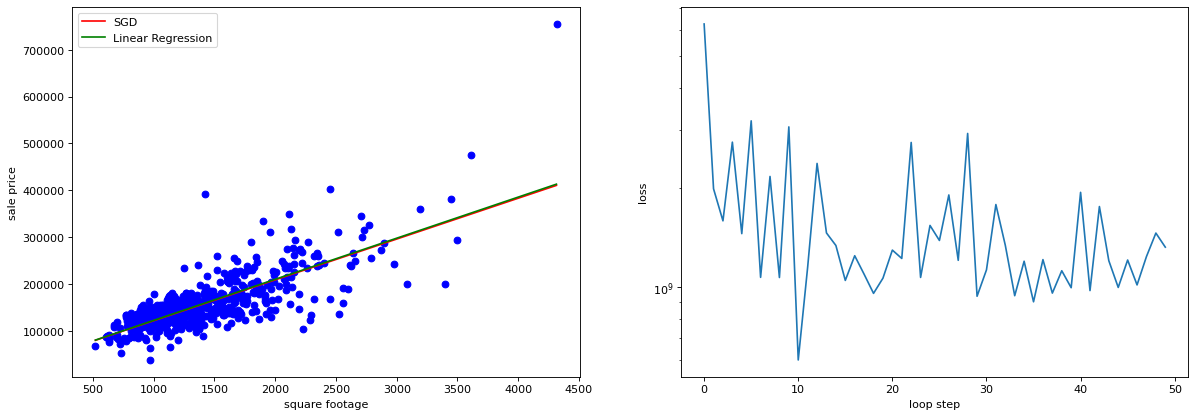

In [125]:
# Comparing stochastic gradient descent and simple linear regression.
# 
# Alex Smith (SmithAlexLee30@gmail.com)
# 9/23/22

from pandas import read_csv, DataFrame
from numpy import arange, sum, power, mean, asarray
from matplotlib import pyplot
from typing import Tuple, List
from IPython import get_ipython

def linear_regression(xs, ys, n: int):
   sum_xy = sum(xs * ys)
   sum_x = sum(xs)
   sum_y = sum(ys)
   sum_x2 = sum(xs * xs)
   denominator = n * sum_x2 - sum_x * sum_x

   m = (n * sum_xy - sum_x * sum_y) / denominator
   b = (sum_y * sum_x2 - sum_x * sum_xy) / denominator

   return m, b

def linear_model(xs, m: float, b: float):
   return m * xs + b

def calc_loss(xs, ys, m: float, b: float):
   predictedYs = linear_model(xs, m, b)
   return power(ys - predictedYs, 2)

def update_m(xs, ys, m: float, b: float, learningRate: float):
   dL_dm = - 2 * xs * (ys - linear_model(xs, m, b))
   dL_dm = mean(dL_dm)
   return m - learningRate * dL_dm

def update_b(xs, ys, m: float, b: float, learningRate: float):
   dL_db = - 2 * (ys - linear_model(xs, m, b))
   dL_db = mean(dL_db)
   return b - learningRate * dL_db

def calc_decay(t, y0, decayRate: float):
   return y0 * power(1 - decayRate, t)

def sgd(data: DataFrame, xName: str, yName: str, 
      m0: float, b0: float, lRateM0: float, lRateB0: float, 
      numIterations: int, batchSize: int, decayRate: float) -> Tuple[float, float, List[float]]:
   newM = m0
   newB = b0
   newRateM0: float = lRateM0
   newRateB0: float = lRateB0
   losses = []  # List of the losses throughout the calculation.

   # Perform the SGD process 'numIterations' times.
   for i in range(numIterations):
      # Sample the data.
      curSample = data.sample(n=batchSize)
      xs = curSample[xName].to_numpy()
      ys = curSample[yName].to_numpy()

      # Update the slope and intercept based on the current values
      newM = update_m(xs, ys, newM, newB, newRateM0)
      newB = update_b(xs, ys, newM, newB, newRateB0)

      # Decay the learning rates.
      newRateM0 = calc_decay(i, lRateM0, decayRate)
      newRateB0 = calc_decay(i, lRateB0, decayRate)

      # Calculate loss and append it to the history.
      losses.append(mean(calc_loss(xs, ys, newM, newB)))
   
   return (newM, newB, losses)


# ===================================================================== #


sgdM = 5.            # Initial slope.
sgdB = 1000.         # Initial y-intercept.
lRateM0 = 1e-7       # Initial slope learning rate.
lRateB0 = 1e-1       # Initial y-intercept learning rate.
decayRate = 0.1      # Rate a which the m and b learning rates will decay.
batchSize = 100      # Number of values to be randomly sampled from the data for each iteration.
numIterations = 50   # Number of iterations to perform.
dataPath = '../01_machineLearning/slimmed_realestate_data.csv'
xName = 'GrLivArea'
yName = 'SalePrice'

# Read and split real estate data.
data = read_csv(dataPath)
dataX = data[xName].to_numpy() # Convert pandas data to numpy arrays.
dataY = data[yName].to_numpy()
n = len(data)

# Perform the simple linear regression and stochastic gradient decent (SGD).
linRegM, linRegB = linear_regression(dataX, dataY, n)
sgdM, sgdB, lossHistory = sgd(data, xName, yName, sgdM, sgdB, lRateM0, lRateB0, numIterations, batchSize, decayRate)

# Calculate the x and y values.
regressionXs = arange(dataX.min(), dataX.max())
lossXs = arange(0, numIterations)

linRegYs = regressionXs * linRegM + linRegB
sgdYs = regressionXs * sgdM + sgdB
lossYs = asarray(lossHistory)

# Print the final linear models of each method.
print('SGD:     y = %.2f * x + %.2f\nLin Reg: y = %.2f * x + %.2f'
   % (sgdM, sgdB, linRegM, linRegB))

# Plot the results.
fig, ax = pyplot.subplots(1, 2, figsize=(18, 6), dpi=80) # Create a 1 by 2 plot grid.

ax[0].set_xlabel('square footage')
ax[0].set_ylabel('sale price')
ax[0].plot(dataX, dataY, 'bo') # Plot the real estate data points.
ax[0].plot(regressionXs, sgdYs, 'r-', label='SGD') # Plot the SGD line.
ax[0].plot(regressionXs, linRegYs,'g-', label='Linear Regression') # Plot the simple linear regression line.
ax[0].legend()

ax[1].set_yscale('log')
ax[1].set_xlabel('loop step')
ax[1].set_ylabel('loss')
ax[1].plot(lossXs, lossYs) # Plot the loss history.

# Clear the notebook variables.
get_ipython().run_line_magic('reset', '-sf')

3. Follow the example from the previous notebook Linear Regression using SGD and build a loop that properly finds the centers of these 4 clusters using k-means.

Point labels unchanged as of step 2.


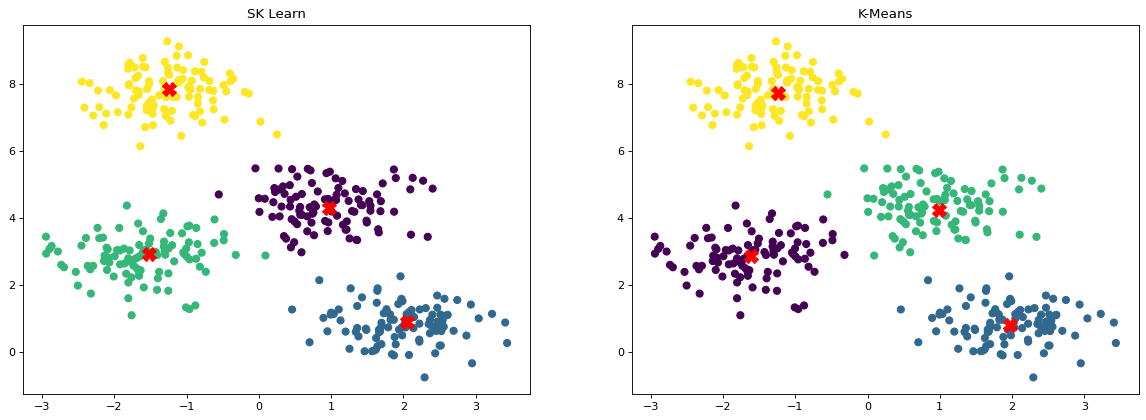

In [126]:
# Clustering data using k-means.
# 
# Alex Smith (SmithAlexLee30@gmail.com)
# 9/26/22

from sklearn.datasets import make_blobs
from numpy import random, arange, array, newaxis, argmin, all, sum
from matplotlib import pyplot
from IPython import get_ipython

def initialize_centroids(x,N):
   x_indices = random.choice(arange(0,x.shape[0]),N)
   centroids = x[x_indices]
   return centroids

def get_new_centroids(x, labels, N):
    """returns the new centroids assigned from the points closest to them"""
    return array([x[labels==k].mean(axis=0) for k in range(N)])

# distance is sqrt( (x - x')**2 + (y - y')**2 )
def assign_labels(x,c):
   # centroids are shape [N,2]
   # x are shape [npoints,2]
   # add middle index to centroids to properly broadcast in math operations
   c = c[:,newaxis,:] # [N,1,2]
   
   # calculate (x - x')**2 and (y - y')**2
   # x is shape [npoints,2], c is [N,1,2] results in an array of shape: [N,npoints,2]
   dist2 = (x - c)**2
   
   # calculate (x - x')**2 + (y - y')**2
   dist2 = dist2.sum(axis=2) # [N,npoints]
   
   # out of the N distances, return the index (0-(N-1)) of the one that is the minimum.
   label = argmin(dist2,axis=0) # [npoints]

   return label

def k_means(x, nCenters, delta):
   last_centroids = initialize_centroids(x, nCenters)
   last_labels = assign_labels(x, last_centroids)

   step = 0
   shouldExit = False
   while not shouldExit:
      centroids = get_new_centroids(x,last_labels, nCenters)
      labels = assign_labels(x, centroids)

      
      if all((last_centroids - centroids) < delta): # Check if centroids stopped moving.
         print(f'Centroids unchanged as of step {step}.')
         shouldExit = True
      elif all(labels == last_labels): # Check if point labels have not changed.
         print(f'Point labels unchanged as of step {step}.')
         shouldExit = True
      else: # Otherwise, update the last labels and centroids.
         last_labels = labels
         last_centroids = centroids
         step += 1

   return last_labels, last_centroids


# ===================================================================== #


nPoints = 400
nCenters = 4
delta = 1e-3

xy, clusterLabels, clusterCenters = make_blobs(n_samples=nPoints, centers=nCenters,
      cluster_std=0.60, random_state=0,
      return_centers=True)

kLabels, kCentroids = k_means(xy, nCenters, delta)

# Plot the results.
fig, ax = pyplot.subplots(1, 2, figsize=(18, 6), dpi=80) # Create a 1 by 2 plot grid.

ax[0].set_title('SK Learn')
ax[0].scatter(xy[:, 0], xy[:, 1], c=clusterLabels, s=40, cmap='viridis') # Plot the SK Learn blobs.
ax[0].plot(clusterCenters[:, 0], clusterCenters[:, 1], 'rX', markersize=12) # Plot the SK Learn centroids.

ax[1].set_title('K-Means')
ax[1].scatter(xy[:, 0], xy[:, 1], c=kLabels, s=40, cmap='viridis') # Plot the K-Means blobs.
ax[1].plot(kCentroids[:, 0], kCentroids[:, 1], 'rX', markersize=12) # Plot the K-Means centroids.

# Clear the notebook variables.
get_ipython().run_line_magic('reset', '-sf')